<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por palabras

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Como ejemplo se utilizará como corpus un dataset canciones de bandas de habla inglés.

In [2]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

--2024-08-31 14:11:59--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2024-08-31 14:11:59--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2024-08-31 14:12:00--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.

In [3]:
# Posibles bandas
os.listdir("./songs_dataset/")

['nirvana.txt',
 'kanye.txt',
 'amy-winehouse.txt',
 'dj-khaled.txt',
 'jimi-hendrix.txt',
 'nursery_rhymes.txt',
 'janisjoplin.txt',
 'Lil_Wayne.txt',
 'Kanye_West.txt',
 'lorde.txt',
 'beatles.txt',
 'notorious_big.txt',
 'kanye-west.txt',
 'r-kelly.txt',
 'notorious-big.txt',
 'bjork.txt',
 'joni-mitchell.txt',
 'nicki-minaj.txt',
 'missy-elliott.txt',
 'johnny-cash.txt',
 'nickelback.txt',
 'rihanna.txt',
 'cake.txt',
 'al-green.txt',
 'disney.txt',
 'patti-smith.txt',
 'dickinson.txt',
 'lady-gaga.txt',
 'bieber.txt',
 'leonard-cohen.txt',
 'prince.txt',
 'britney-spears.txt',
 'radiohead.txt',
 'dr-seuss.txt',
 'paul-simon.txt',
 'alicia-keys.txt',
 'ludacris.txt',
 'blink-182.txt',
 'adele.txt',
 'bruno-mars.txt',
 'lin-manuel-miranda.txt',
 'drake.txt',
 'lil-wayne.txt',
 'michael-jackson.txt',
 'dolly-parton.txt',
 'eminem.txt',
 'bob-dylan.txt',
 'bob-marley.txt',
 'bruce-springsteen.txt']

In [4]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)
df.head()

<ipython-input-4-91c4bad52ba1>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)


,0
0,"Yesterday, all my troubles seemed so far away"
1,Now it looks as though they're here to stay
2,"Oh, I believe in yesterday Suddenly, I'm not h..."
3,There's a shadow hanging over me.
4,"Oh, yesterday came suddenly Why she had to go ..."


Consideraremos que cada secuencia para este dataset es un verso.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos los versos del dataset y ses explorará la cantidad de términos presentes.



In [5]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1846


### Elegir el tamaño del contexto

In [6]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [7]:
# cada verso lo guardamos en una lista
text = list(df.loc[:,0])
text

['Yesterday, all my troubles seemed so far away',
 "Now it looks as though they're here to stay",
 "Oh, I believe in yesterday Suddenly, I'm not half the man I used to be",
 "There's a shadow hanging over me.",
 "Oh, yesterday came suddenly Why she had to go I don't know she wouldn't say",
 'I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play',
 'Now I need a place to hide away',
 "Oh, I believe in yesterday Why she had to go I don't know she wouldn't say",
 'I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play',
 'Now I need a place to hide away',
 'Oh, I believe in yesterday',
 'Mm mm mm mm mm mm mm When I find myself in times of trouble, Mother Mary comes to me',
 'Speaking words of wisdom, let it be',
 'And in my hour of darkness she is standing right in front of me',
 'Speaking words of wisdom, let it be',
 'Let it be, let it be, let it be, let it be',
 'Whisper words of wisdom, let it be And when

In [8]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [9]:
text[0]

'Yesterday, all my troubles seemed so far away'

In [10]:
segmented_sentences[0]

['yesterday', 'all', 'my', 'troubles', 'seemed', 'so', 'far', 'away']

In [11]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([ 29., 305., 221., 523., 293.,  72., 180.,  97.,  42.,  39.,  22.,
         12.,   4.,   3.,   0.,   0.,   2.,   1.,   0.,   1.]),
 array([ 1.  ,  2.65,  4.3 ,  5.95,  7.6 ,  9.25, 10.9 , 12.55, 14.2 ,
        15.85, 17.5 , 19.15, 20.8 , 22.45, 24.1 , 25.75, 27.4 , 29.05,
        30.7 , 32.35, 34.  ]),
 <BarContainer object of 20 artists>)

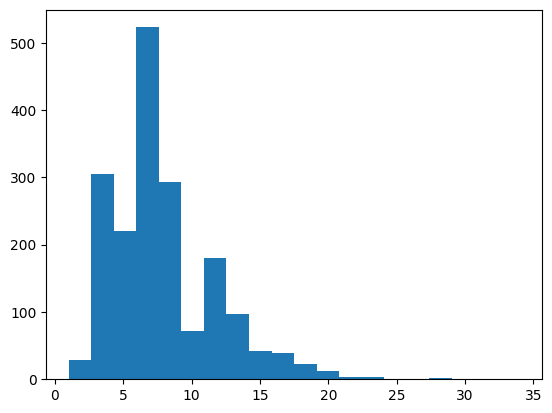

In [12]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [13]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 12


###  Tokenizar

In [14]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [15]:
tokenized_sentences[0]

[200, 10, 12, 907, 908, 42, 909, 121]

In [16]:
segmented_sentences[0]

['yesterday', 'all', 'my', 'troubles', 'seemed', 'so', 'far', 'away']

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [17]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

\Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

Por ejemplo, si tenemos el texto *La bella y graciosa moza marchóse a lavar la ropa* y nuestro contexto es de 5 palabras, tendremos:

- *La bella y graciosa moza*
- *bella y graciosa moza marchóse*
- *y graciosa moza marchóse a*
- *graciosa moza marchóse a lavar*
- *moza marchóse a lavar la*
- *marchóse a lavar la ropa*

In [18]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [19]:
len(tok_sent)

1957

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

- *La hermosa casa en el prado*
- *La hermosa*
- *La hermosa casa*
- *La hermosa casa en*
- *La hermosa casa en el*
- *La hermosa casa en el prado*

In [20]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [21]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [22]:
train_seqs.shape

(15325, 13)

In [23]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

In [24]:
y.shape

(15325, 12)

In [25]:
# Palabras del vocabulario
tok.index_word

{1: 'you',
 2: 'i',
 3: 'the',
 4: 'to',
 5: 'and',
 6: 'love',
 7: 'a',
 8: 'me',
 9: 'in',
 10: 'all',
 11: 'nah',
 12: 'my',
 13: 'it',
 14: 'know',
 15: 'be',
 16: 'that',
 17: 'of',
 18: 'on',
 19: 'she',
 20: 'is',
 21: 'say',
 22: 'now',
 23: 'oh',
 24: 'yeah',
 25: 'your',
 26: 'get',
 27: "don't",
 28: 'back',
 29: 'let',
 30: 'with',
 31: 'her',
 32: 'can',
 33: "it's",
 34: 'do',
 35: "i'm",
 36: 'when',
 37: 'come',
 38: 'will',
 39: 'he',
 40: 'but',
 41: 'for',
 42: 'so',
 43: 'need',
 44: 'there',
 45: 'like',
 46: 'no',
 47: 'together',
 48: "i'll",
 49: 'see',
 50: 'was',
 51: 'never',
 52: 'we',
 53: 'down',
 54: 'way',
 55: 'if',
 56: 'want',
 57: 'out',
 58: 'hey',
 59: 'one',
 60: 'got',
 61: 'go',
 62: 'well',
 63: "can't",
 64: 'girl',
 65: 'good',
 66: 'his',
 67: 'sun',
 68: 'they',
 69: 'home',
 70: 'hello',
 71: 'day',
 72: 'are',
 73: 'ah',
 74: 'right',
 75: 'little',
 76: 'at',
 77: 'from',
 78: 'man',
 79: 'here',
 80: 'help',
 81: 'gonna',
 82: 'have',
 

In [26]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1628

In [27]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'you': 1, 'i': 2, 'the': 3, 'to': 4, 'and': 5, 'love': 6, 'a': 7, 'me': 8, 'in': 9, 'all': 10, 'nah': 11, 'my': 12, 'it': 13, 'know': 14, 'be': 15, 'that': 16, 'of': 17, 'on': 18, 'she': 19, 'is': 20, 'say': 21, 'now': 22, 'oh': 23, 'yeah': 24, 'your': 25, 'get': 26, "don't": 27, 'back': 28, 'let': 29, 'with': 30, 'her': 31, 'can': 32, "it's": 33, 'do': 34, "i'm": 35, 'when': 36, 'come': 37, 'will': 38, 'he': 39, 'but': 40, 'for': 41, 'so': 42, 'need': 43, 'there': 44, 'like': 45, 'no': 46, 'together': 47, "i'll": 48, 'see': 49, 'was': 50, 'never': 51, 'we': 52, 'down': 53, 'way': 54, 'if': 55, 'want': 56, 'out': 57, 'hey': 58, 'one': 59, 'got': 60, 'go': 61, 'well': 62, "can't": 63, 'girl': 64, 'good': 65, 'his': 66, 'sun': 67, 'they': 68, 'home': 69, 'hello': 70, 'day': 71, 'are': 72, 'ah': 73, 'right': 74, 'little': 75, 'at': 76, 'from': 77, 'man': 78, 'here': 79, 'help': 80, 'gonna': 81, 'have': 82, 'not': 83, 'world': 84, 'going': 85, 'what': 86, 'still': 87, 'how': 88, 'too': 89

In [28]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'so': 61, 'yesterday': 10, 'my': 134, 'all': 177, 'far': 1, 'seemed': 1, 'away': 21, 'troubles': 1, 'to': 307, 'it': 125, 'looks': 2, 'now': 90, 'stay': 7, 'here': 33, "they're": 5, 'though': 11, 'as': 25, 'be': 108, 'the': 376, "i'm": 66, 'suddenly': 3, 'man': 34, 'i': 400, 'not': 32, 'half': 1, 'used': 1, 'believe': 15, 'in': 186, 'oh': 77, 'over': 5, "there's": 14, 'a': 270, 'shadow': 1, 'hanging': 1, 'me': 219, 'go': 38, 'came': 11, "wouldn't": 4, 'why': 20, 'know': 132, 'say': 76, 'she': 90, "don't": 74, 'had': 19, 'wrong': 6, 'something': 13, 'long': 25, 'an': 15, 'for': 62, 'was': 48, 'game': 3, 'play': 10, 'easy': 9, 'love': 181, 'said': 14, 'such': 9, 'place': 10, 'need': 51, 'hide': 13, 'myself': 3, 'mother': 2, 'comes': 20, 'find': 10, 'mary': 2, 'mm': 3, 'trouble': 1, 'when': 71, 'times': 5, 'of': 109, 'speaking': 4, 'let': 55, 'words': 14, 'wisdom': 7, 'right': 25, 'front': 1, 'and': 311, 'is': 89, 'hour': 1, 'darkness': 1, 'standing': 13, 'whis


### Definir el modelo

In [30]:
model = Sequential()

# Probamos Modificando la reda, utilizando embeddings de mayor tamano y mayor cantidad de neuronas LSTM

# La primera capa es de embedding entrenable. He aumentado el tamaño del embedding.
model.add(Embedding(input_dim=vocab_size + 1, output_dim=100, input_shape=(None,)))

# Primera capa LSTM con Dropout para regularización
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.3))

# Segunda capa LSTM con Dropout para regularización
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.3))

# Capa Dense adicional para capturar características más complejas
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Capa de predicción final con softmax
model.add(Dense(vocab_size + 1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, None, 100)           │         162,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, None, 150)           │         150,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 150)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, None, 150)           │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 150)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 64)            │           9,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, None, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, None, 1629)          │         105,885 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 609,649 (2.33 MB)

 Trainable params: 609,649 (2.33 MB)

 Non-trainable params: 0 (0.00 B)

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [33]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("best_model_workd.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [34]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)

Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 3.0552
 mean perplexity: 1098.948714618877 

Saved new model!
240/240 ━━━━━━━━━━━━━━━━━━━━ 33s 138ms/step - loss: 3.0551
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 2.9409
 mean perplexity: 1464.8282845891579 

240/240 ━━━━━━━━━━━━━━━━━━━━ 41s 140ms/step - loss: 2.9408
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 2.8365
 mean perplexity: 942.4344176644055 

Saved new model!
240/240 ━━━━━━━━━━━━━━━━━━━━ 41s 141ms/step - loss: 2.8364
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 2.7450
 mean perplexity: 886.4392618798606 

Saved new model!
240/240 ━━━━━━━━━━━━━━━━━━━━ 43s 150ms/step - loss: 2.7449
Epoch 5/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 2.6614
 mean perplexity: 1066.012756675395 

240/240 ━━━━━━━━━━━━━━━━━━━━ 39s 142ms/step - loss: 2.6613
Epoch 6/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 2.5826
 mean perplexity: 908.5365518093914 

240/240 ━━━

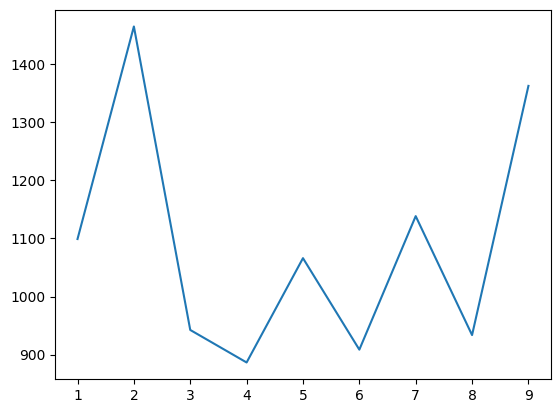

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [36]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('best_model_workd.keras')


### Predicción de próxima palabra

In [37]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.4 MB/s eta 0:00:00


In [38]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://1270ff48db90a8c691.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1270ff48db90a8c691.gradio.live


### Generación de secuencias

In [39]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [40]:
input_text='hey jude don\'t'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


"hey jude don't to a hard day's day's night i the little night"

###  Beam search y muestreo aleatorio

In [41]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [42]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [43]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="when i find myself in times",temp=1,mode='sto')

In [44]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 18)

In [45]:
# veamos las salidas
decode(salidas[0])

['when i find myself in times and the doors is the song']

Se observa que el modelo no logra aprender  a construir oraciones con sentido, tanto en cuanto al significado como a la gramatica.